In [38]:
import matplotlib.pyplot as plt
import IPython
import speech as sp
%matplotlib inline
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [39]:
import speech as sp
import numpy as np
# Parameters 

p = 100 #Order of the all pole filter
frame_size = 400 # Window size
iterations = 10 # Number of iterations of the Wiener Filter

# Preparing the sample
y_clean, sr = sp.data.load('../samples/speech_male/arctic_a0001.wav')
# For now : choose the SNR (Db) and add corresponding noise to the signal
SNR = 3
y = sp.data.add_noise_from_file(y_clean,sr,'../samples/noise/crowd.wav',SNR)

#y_filtered = lowpass_filter(y,sr,4800)
y_filtered = y
# Get the list of frames for the STFT filtering
list_frames,y_padded,w_a,w_s = sp.data.frame_split(y_filtered,frame_size)
n_frames = len(list_frames)

wiener_filter = np.zeros(int(frame_size//2)+1)
s = np.zeros(y_padded.shape)
y_clean_padded = np.concatenate((y_clean,np.zeros(len(y_padded)-len(y_clean))))
noise_PSD = np.var(y_padded[:frame_size])
for frame in range(n_frames):
    idx = list_frames[frame]
    if(np.sum((w_a*y_padded[idx])**2) > frame_size*noise_PSD):
        denoised,wiener_filter,_,_ = sp.process.denoise_frame(w_a*y_padded[idx],p,noise_PSD,iterations)
        s[idx] = s[idx] + w_s*denoised
    else:
        s[idx] = s[idx] + w_s*(np.fft.irfft(wiener_filter*np.fft.rfft(w_a*y_padded[idx])))

s = s/np.std(s)

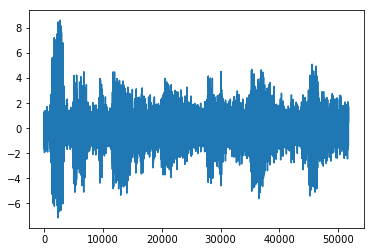

In [40]:
# Plot and play the noisy signal

plt.plot(y_filtered)
IPython.display.Audio(y_filtered,rate=sr)

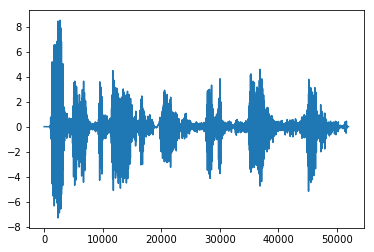

In [41]:
#Plot and play the denoised signal
plt.plot(s)
IPython.display.Audio(s,rate=sr)

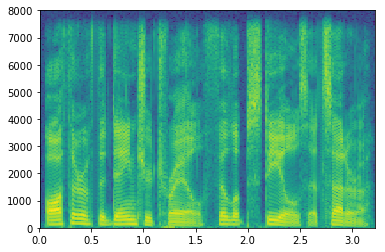

In [42]:
_,_,_, im_clean = plt.specgram(y_clean,NFFT = frame_size, Fs = sr)

/home/lcolbois/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:7235: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


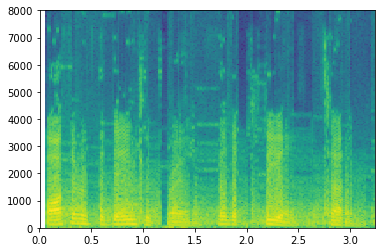

In [44]:
_,_,_, im_denoised = plt.specgram(s, NFFT = frame_size,Fs = sr)

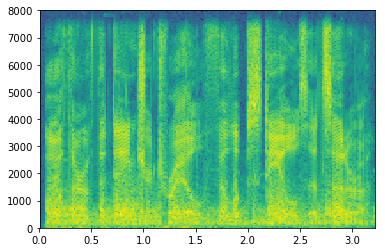

In [45]:
_,_,_, im_delta = plt.specgram(s[:len(y_clean)]-y_clean, NFFT = frame_size,Fs = sr,)


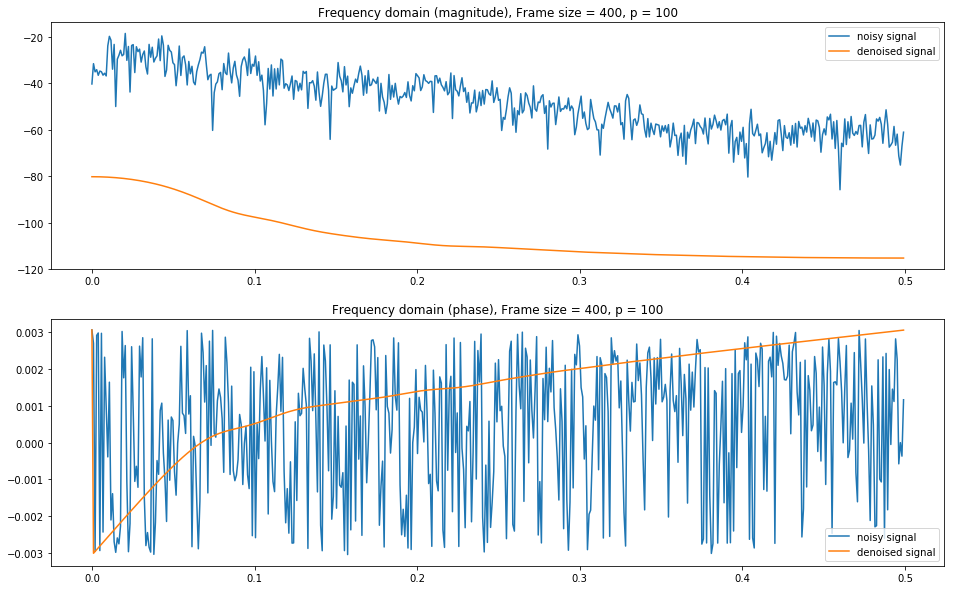

In [46]:
N = 1024
S = np.fft.fftshift(np.fft.fft(s, N))
Y = np.fft.fftshift(np.fft.fft(y, N))
freq = np.fft.fftshift(np.fft.fftfreq(N))
ind = [ind for ind, values in enumerate(freq) if values >= 0]

fig, axes = plt.subplots(2, 1, figsize=(16, 10))
# Plot spectrum (Magnitude)
axes[0].plot(freq[ind], 20*np.log10(np.abs(Y[ind])/N),label='noisy signal')
axes[0].plot(freq[ind], 20*np.log10(np.abs(S[ind])/N),label='denoised signal')
axes[0].legend()
axes[0].set_title('Frequency domain (magnitude), Frame size = {}, p = {}'.format(frame_size,p))

# Plot spectrum (Phase)
axes[1].plot(freq[ind], np.angle(Y[ind])/N,label='noisy signal')
axes[1].plot(freq[ind], np.angle(S[ind])/N,label='denoised signal')
axes[1].legend()
axes[1].set_title('Frequency domain (phase), Frame size = {}, p = {}'.format(frame_size,p))

plt.show()